In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [7]:
# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

   Release Year                            Title Origin/Ethnicity  \
0          1907  How Brown Saw the Baseball Game         American   
1          1907                     Laughing Gas         American   
2          1908         The Adventures of Dollie         American   
3          1908                  The Black Viper         American   
4          1908           A Calamitous Elopement         American   

               Director                               Cast   Genre  \
0               Unknown                            Unknown  comedy   
1  Edwin Stanton Porter    Bertha Regustus, Edward Boulden  comedy   
2        D. W. Griffith  Arthur V. Johnson, Linda Arvidson   drama   
3        D. W. Griffith                     D. W. Griffith   drama   
4         D.W. Griffith       Harry Solter, Linda Arvidson  comedy   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
1  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...

In [8]:
# Encode 'Origin/Ethnicity' and 'Genre'
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])

# Tokenize 'Title' and 'Cast' for Word2Vec
data['Title_Tokens'] = data['Title'].fillna('').apply(lambda x: x.split())
data['Cast_Tokens'] = data['Cast'].fillna('').apply(lambda x: x.split(','))

# Train Word2Vec for 'Title' and 'Cast'
title_w2v_model = Word2Vec(sentences=data['Title_Tokens'], vector_size=100, window=3, min_count=1, workers=4)
cast_w2v_model = Word2Vec(sentences=data['Cast_Tokens'], vector_size=100, window=3, min_count=1, workers=4)

In [9]:
# Function to get Word2Vec embeddings
def get_w2v_embedding(tokens, model, vector_size):
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

# Generate embeddings for 'Title' and 'Cast'
data['Title_Embedding'] = data['Title_Tokens'].apply(lambda x: get_w2v_embedding(x, title_w2v_model, 100))
data['Cast_Embedding'] = data['Cast_Tokens'].apply(lambda x: get_w2v_embedding(x, cast_w2v_model, 100))

# Expand embedding columns into separate features
title_embeddings = np.vstack(data['Title_Embedding'].values)
cast_embeddings = np.vstack(data['Cast_Embedding'].values)

In [10]:
# Drop non-numeric columns (keeping embeddings)
data = data.drop(columns=['Title', 'Cast', 'Wiki Page', 'Plot', 'Title_Tokens', 'Cast_Tokens'])


In [11]:
# Combine all features
numeric_features = data[['Release Year', 'Origin/Ethnicity']].values
combined_features = np.hstack((numeric_features, title_embeddings, cast_embeddings))

# Add refined statistical features
max_title_embedding = np.max(title_embeddings, axis=1).reshape(-1, 1)
max_cast_embedding = np.max(cast_embeddings, axis=1).reshape(-1, 1)
var_title_embedding = np.var(title_embeddings, axis=1).reshape(-1, 1)
var_cast_embedding = np.var(cast_embeddings, axis=1).reshape(-1, 1)
std_title_embedding = np.std(title_embeddings, axis=1).reshape(-1, 1)
std_cast_embedding = np.std(cast_embeddings, axis=1).reshape(-1, 1)

# Add features to the combined features
combined_features = np.hstack((
    combined_features,
    max_title_embedding,
    max_cast_embedding,
    var_title_embedding,
    var_cast_embedding,
    std_title_embedding,
    std_cast_embedding
))

In [12]:
# Standardize all features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_features)

In [13]:
# Apply SMOTE
true_labels = data['Genre']  # Replace with true labels if available
smote = SMOTE(random_state=42)
data_balanced, true_labels_balanced = smote.fit_resample(data_scaled, true_labels)
print("Data shape after SMOTE:", data_balanced.shape)
print("Class distribution after SMOTE:", pd.Series(true_labels_balanced).value_counts())

Data shape after SMOTE: (35046, 208)
Class distribution after SMOTE: Genre
comedy      5841
drama       5841
horror      5841
romance     5841
thriller    5841
action      5841
Name: count, dtype: int64


In [14]:
# Reduce to 5 principal components
pca = PCA(n_components=10)
data_reduced = pca.fit_transform(data_balanced)

In [16]:

n_clusters = len(np.unique(true_labels_balanced))
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, algorithm='lloyd', init='k-means++', n_init=20, max_iter=1000, tol=1e-4)
kmeans_labels = kmeans_model.fit_predict(data_reduced)

# Evaluate K-Means
print("\nK-Means Results:")
kmeans_silhouette = silhouette_score(data_reduced, kmeans_labels)
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
kmeans_ari = adjusted_rand_score(true_labels_balanced, kmeans_labels)
print(f"Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
kmeans_nmi = normalized_mutual_info_score(true_labels_balanced, kmeans_labels)
print(f"Normalized Mutual Information (NMI): {kmeans_nmi:.4f}")


K-Means Results:
Silhouette Score: 0.2136
Adjusted Rand Index (ARI): 0.0290
Normalized Mutual Information (NMI): 0.0358


In [ ]:
# Visualize K-Means clustering
plt.figure(figsize=(10, 6))
scatter_kmeans = plt.scatter(
    data_reduced[:, 0],
    data_reduced[:, 1],
    c=kmeans_labels, cmap='viridis', s=10
)
plt.colorbar(scatter_kmeans, label="Cluster Labels")
plt.title("2D PCA Visualization of K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

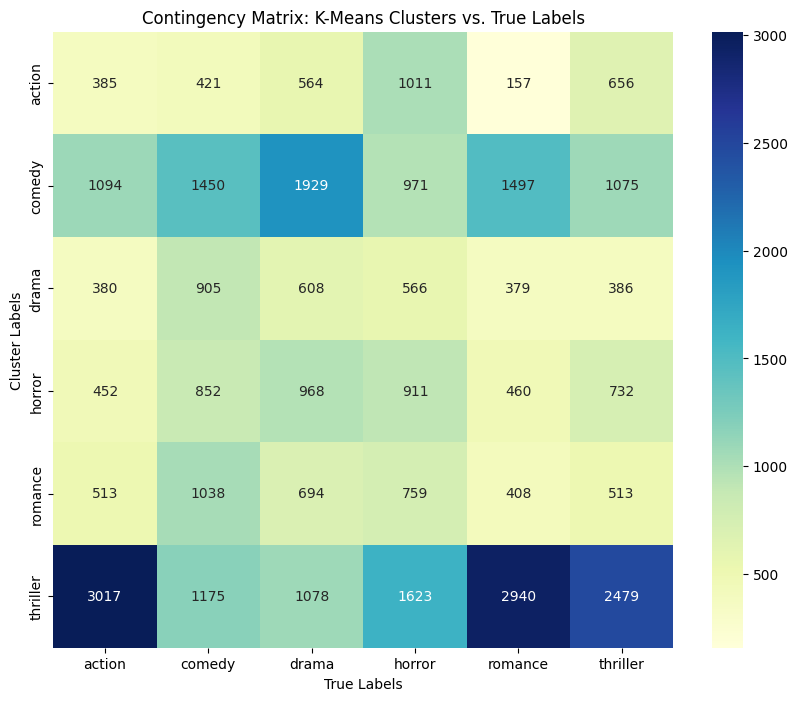

In [24]:
# Generate Contingency Matrix for K-Means
contingency_kmeans = pd.crosstab(kmeans_labels, true_labels_balanced)
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_kmeans, annot=True, fmt="d", cmap="YlGnBu", cbar=True, xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Contingency Matrix: K-Means Clusters vs. True Labels")
plt.xlabel("True Labels")
plt.ylabel("Cluster Labels")
plt.show()


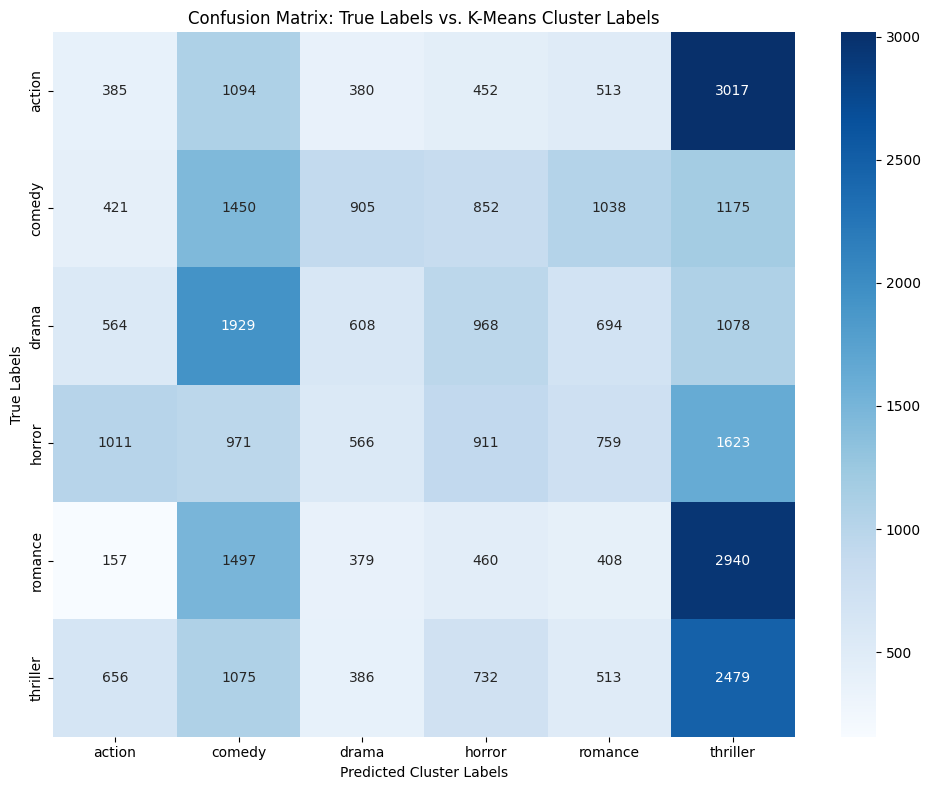

In [23]:
# Fit the LabelEncoder on the entire range of labels
label_encoder.fit(data['Genre'])  # Ensure 'Genre' column contains all unique labels

# Encode true labels to numeric
true_labels_encoded = label_encoder.transform(true_labels_balanced)

# Generate a confusion matrix for K-Means clustering
conf_matrix = confusion_matrix(true_labels_encoded, kmeans_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix: True Labels vs. K-Means Cluster Labels")
plt.xlabel("Predicted Cluster Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [25]:
# Hungarian Algorithm to find the best label alignment
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Compute accuracy based on the optimal assignment
cluster_accuracy = conf_matrix[row_ind, col_ind].sum() / true_labels_encoded.size

print(f"Cluster Accuracy Score: {cluster_accuracy:.4f}")


Cluster Accuracy Score: 0.2313


In [26]:
# Define a function to compute accuracy based on best alignment
def cluster_accuracy_score(true_labels, cluster_labels):
    # Get the unique labels
    unique_true_labels = np.unique(true_labels)
    unique_cluster_labels = np.unique(cluster_labels)
    
    # Create a cost matrix where each entry is the negative number of matches
    cost_matrix = np.zeros((len(unique_true_labels), len(unique_cluster_labels)))
    for i, true_label in enumerate(unique_true_labels):
        for j, cluster_label in enumerate(unique_cluster_labels):
            cost_matrix[i, j] = -np.sum((true_labels == true_label) & (cluster_labels == cluster_label))
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Compute the total number of matches for the optimal assignment
    total_matches = -cost_matrix[row_ind, col_ind].sum()
    
    # Return accuracy
    return total_matches / len(true_labels)

# Calculate cluster accuracy
accuracy = cluster_accuracy_score(true_labels_balanced, kmeans_labels)
print(f"Cluster Accuracy Score: {accuracy:.4f}")

Cluster Accuracy Score: 0.2313
